In [66]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('data/HR_data.csv')

#print header
print(data.head())

   Unnamed: 0  HR_TD_Mean  HR_TD_Median  HR_TD_std  HR_TD_Min  HR_TD_Max  \
0           0   78.663878         76.70   7.480043      67.25      92.48   
1           1   76.540732         76.61   2.584756      69.82      82.33   
2           2   78.173563         77.92   2.681255      72.22      82.80   
3           3   83.073688         83.88   7.363598      69.42      96.12   
4           4   72.281250         72.91   3.193762      64.95      79.98   

   HR_TD_AUC  HR_TD_Kurtosis  HR_TD_Skew  HR_TD_Slope_min  ...  upset  \
0  23048.450       -1.091448    0.369955          -0.7300  ...    1.0   
1  23959.920       -0.245338    0.338732          -0.3600  ...    2.0   
2  20324.605       -0.615922   -0.233047          -0.6300  ...    1.0   
3  24924.300       -0.866610   -0.046021          -0.4650  ...    1.0   
4  23052.100        0.200401   -0.560948          -0.3725  ...    3.0   

   hostile  alert  ashamed  inspired  nervous  attentive  afraid  active  \
0      1.0    2.0      1.0  

In [67]:
print(data[data.isna().any(axis=1)])
data = data.dropna()
print(data.head())

     Unnamed: 0  HR_TD_Mean  HR_TD_Median  HR_TD_std  HR_TD_Min  HR_TD_Max  \
104         104   83.758589        83.075   3.465654      78.33      93.55   
120         120   64.966797        62.725   7.655497      57.32      89.38   
122         122   69.815920        72.050   4.761262      59.43      75.38   
125         125   69.222492        65.350  10.880043      57.62      94.38   
272         272   84.923904        86.950   7.378264      67.25      98.45   

     HR_TD_AUC  HR_TD_Kurtosis  HR_TD_Skew  HR_TD_Slope_min  ...  upset  \
104  27219.015        1.316130    1.257816          -0.4300  ...    1.0   
120  19803.415        3.132358    1.991410          -0.9325  ...    2.0   
122  20807.725       -0.755575   -0.801089          -0.5125  ...    2.0   
125  21041.055       -0.330384    1.044434          -0.7600  ...    3.0   
272  21224.175       -0.716559   -0.555002          -3.3660  ...    1.0   

     hostile  alert  ashamed  inspired  nervous  attentive  afraid  active  \
10

In [68]:
#from column Round in features, leftstrip the string 'round_' and convert to int
data['Round'] = data['Round'].str.lstrip('round_').astype(int)
#same with column Phase, lefstrip 'phase' and convert to int
data['Phase'] = data['Phase'].str.lstrip('phase').astype(int)
print(data.head())

   Unnamed: 0  HR_TD_Mean  HR_TD_Median  HR_TD_std  HR_TD_Min  HR_TD_Max  \
0           0   78.663878         76.70   7.480043      67.25      92.48   
1           1   76.540732         76.61   2.584756      69.82      82.33   
2           2   78.173563         77.92   2.681255      72.22      82.80   
3           3   83.073688         83.88   7.363598      69.42      96.12   
4           4   72.281250         72.91   3.193762      64.95      79.98   

   HR_TD_AUC  HR_TD_Kurtosis  HR_TD_Skew  HR_TD_Slope_min  ...  upset  \
0  23048.450       -1.091448    0.369955          -0.7300  ...    1.0   
1  23959.920       -0.245338    0.338732          -0.3600  ...    2.0   
2  20324.605       -0.615922   -0.233047          -0.6300  ...    1.0   
3  24924.300       -0.866610   -0.046021          -0.4650  ...    1.0   
4  23052.100        0.200401   -0.560948          -0.3725  ...    3.0   

   hostile  alert  ashamed  inspired  nervous  attentive  afraid  active  \
0      1.0    2.0      1.0  

### Supervised model part

In [69]:
import warnings  # to silence convergence warnings

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch

import sklearn as sk
from sklearn.decomposition import PCA, SparsePCA
from sklearn.cross_decomposition import PLSRegression
from sklearn.ensemble import AdaBoostRegressor
from sklearn.linear_model import (
    LinearRegression, LogisticRegression, LogisticRegressionCV,
    Ridge, Lasso, ElasticNet, Lars, LassoLars
)
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor

from xgboost import XGBRegressor
from sklearn.cross_decomposition import CCA
from sklearn.metrics import r2_score

### data prep supervised model

In [70]:
# Define your Y columns as a list
emotion_columns = ['Frustrated', 'upset', 'hostile', 'alert', 'ashamed',
                  'inspired', 'nervous', 'attentive', 'afraid', 'active', 'determined']

# Create Y as the selected columns
Y_full_df = data[emotion_columns]

# Create X as all columns except those in target_columns
X_full_df = data.drop(columns=emotion_columns)

print(X_full_df.columns, Y_full_df.columns)

Index(['Unnamed: 0', 'HR_TD_Mean', 'HR_TD_Median', 'HR_TD_std', 'HR_TD_Min',
       'HR_TD_Max', 'HR_TD_AUC', 'HR_TD_Kurtosis', 'HR_TD_Skew',
       'HR_TD_Slope_min', 'HR_TD_Slope_max', 'HR_TD_Slope_mean', 'HR_TD_Slope',
       'TEMP_TD_Mean', 'TEMP_TD_Median', 'TEMP_TD_std', 'TEMP_TD_Min',
       'TEMP_TD_Max', 'TEMP_TD_AUC', 'TEMP_TD_Kurtosis', 'TEMP_TD_Skew',
       'TEMP_TD_Slope_min', 'TEMP_TD_Slope_max', 'TEMP_TD_Slope_mean',
       'TEMP_TD_Slope', 'EDA_TD_P_Mean', 'EDA_TD_P_Median', 'EDA_TD_P_std',
       'EDA_TD_P_Min', 'EDA_TD_P_Max', 'EDA_TD_P_AUC', 'EDA_TD_P_Kurtosis',
       'EDA_TD_P_Skew', 'EDA_TD_P_Slope_min', 'EDA_TD_P_Slope_max',
       'EDA_TD_P_Slope_mean', 'EDA_TD_P_Slope', 'EDA_TD_T_Mean',
       'EDA_TD_T_Median', 'EDA_TD_T_std', 'EDA_TD_T_Min', 'EDA_TD_T_Max',
       'EDA_TD_T_AUC', 'EDA_TD_T_Kurtosis', 'EDA_TD_T_Skew',
       'EDA_TD_T_Slope_min', 'EDA_TD_T_Slope_max', 'EDA_TD_T_Slope_mean',
       'EDA_TD_T_Slope', 'EDA_TD_P_Peaks', 'EDA_TD_P_RT', 'EDA_TD_P_R

##### 1 Split dataset based on cohort value (merging all groups pertaining to cohort 3)
##### 2 Remove individual and cohort as features of X
##### 3 onehot encode categorical variables: This includes, round, phase and puzzler. 
##### 4 Choose the column that we will predict of Y (for the "other supervised models"). CCA predicts all emotions. 

In [71]:
class CohortCVSplitter:
    def __init__(self, cohort_array):
        self.cohort_array = np.array(cohort_array)
        self.unique_cohorts = np.unique(self.cohort_array)

    def split(self, X, y=None):
        for cohort in self.unique_cohorts:
            test_index = np.where(self.cohort_array == cohort)[0]
            train_index = np.where(self.cohort_array != cohort)[0]
            yield train_index, test_index

    def get_n_splits(self, X=None, y=None, groups=None):
        return len(self.unique_cohorts)
    
def preprocess_entire_X(X_full):
    X_full = X_full.drop(columns=['Individual', 'Cohort'], errors='ignore')
    print("Dropping individual and cohort columns")
    categorical_cols = ['Round', 'Phase', 'Puzzler']
    X_cat = X_full[categorical_cols].astype(str)
    X_num = X_full.drop(columns=categorical_cols, errors='ignore')
    encoder = OneHotEncoder(sparse_output=False, drop='first')
    X_cat_encoded = encoder.fit_transform(X_cat)
    X_processed = np.hstack([X_num.values, X_cat_encoded])
    return X_processed, encoder


Xfull, encoder = preprocess_entire_X(X_full_df)

"""
Merge groups of cohort 3
"""
mapping = {
    'D1_1': 'group1',
    'D1_2': 'group2'
}
data['Cohort'] = data['Cohort'].map(mapping).fillna('group3')
print("new cohort categories", data['Cohort'].unique())

cohort_array = data['Cohort'].values
CV = CohortCVSplitter(cohort_array)

Dropping individual and cohort columns
new cohort categories ['group3' 'group1' 'group2']


In [72]:
Yfull = Y_full_df.values
target_column = 'Frustrated'
Yfull_single_column = Y_full_df[target_column].values  # This will be a (n_samples,) array

lambdas = np.logspace(-2,2,25)
K = 6  #number of cohorts
seed = 69 

### CCA

In [73]:
# Configuration
n_components = min(Xfull.shape[1], Yfull.shape[1])  # choose max allowable components

# To collect results
r2_scores_per_fold = []

# Run CCA over cohort-based CV
for k, (train_index, test_index) in enumerate(CV.split(Xfull, Yfull)):
    print(f"\nRunning CCA on fold {k + 1} (Cohort held out: {np.unique(cohort_array[test_index])})")

    X_train = Xfull[train_index]
    Y_train = Yfull[train_index]
    X_test = Xfull[test_index]
    Y_test = Yfull[test_index]

    # Fit CCA model
    cca = CCA(n_components=n_components)
    cca.fit(X_train, Y_train)

    # Transform test set
    X_test_c, Y_test_c = cca.transform(X_test, Y_test)

    # Compute R² score for each canonical dimension
    r2 = r2_score(Y_test_c, X_test_c, multioutput='raw_values')  # one score per component
    r2_scores_per_fold.append(r2)

    print(f"Fold {k + 1} R² per component: {np.round(r2, 3)}")

# Convert to array for summary
r2_scores_per_fold = np.array(r2_scores_per_fold)
mean_r2_per_component = r2_scores_per_fold.mean(axis=0)

print("\nAverage R² across folds per canonical component:")
print(np.round(mean_r2_per_component, 3))


Running CCA on fold 1 (Cohort held out: ['group1'])
Fold 1 R² per component: [ 0.047 -0.142 -0.08  -0.317 -0.084 -0.081 -0.212 -0.285 -0.08  -0.057
 -0.052]

Running CCA on fold 2 (Cohort held out: ['group2'])
Fold 2 R² per component: [-0.041 -0.14  -0.157 -0.075 -0.926 -0.458 -0.429 -0.084 -0.181 -9.536
 -1.668]

Running CCA on fold 3 (Cohort held out: ['group3'])
Fold 3 R² per component: [ 0.072 -0.022 -0.04  -0.154 -0.022 -0.051 -0.121 -0.057 -0.056 -0.087
 -0.177]

Average R² across folds per canonical component:
[ 0.026 -0.101 -0.092 -0.182 -0.344 -0.197 -0.254 -0.142 -0.106 -3.227
 -0.632]


### Other supervised models
#### loss function plotted = mean absolute error

starting fold 0
starting fold 1
starting fold 2
CV lambda 1 std rule for SVR is 0.6812920690579611
min val error is 1.7817579273645567. This is the RMSE


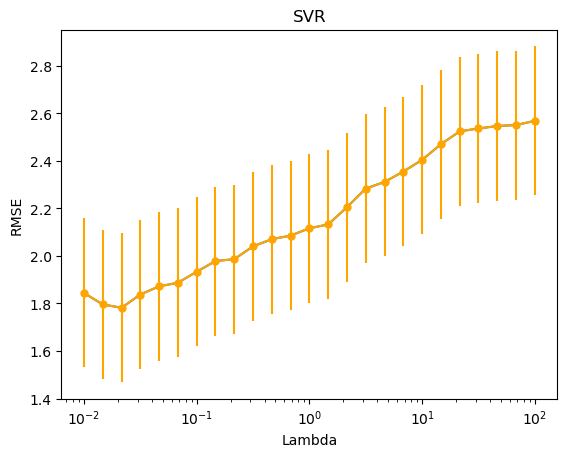

CV lambda 1 std rule for baseline is 100.0
min val error is 1.6796435453479317. This is the RMSE


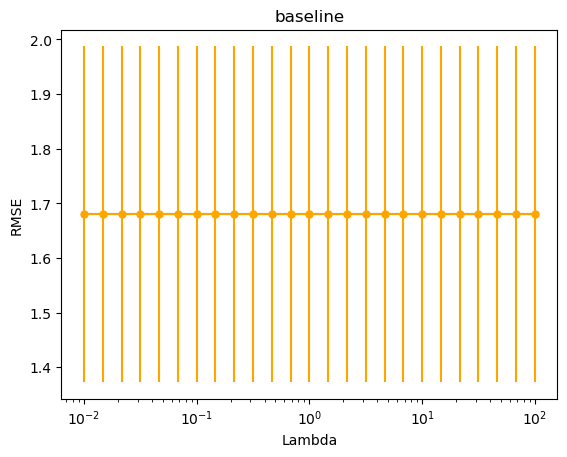

CV lambda 1 std rule for lasso is 100.0
min val error is 1.5834946548693956. This is the RMSE


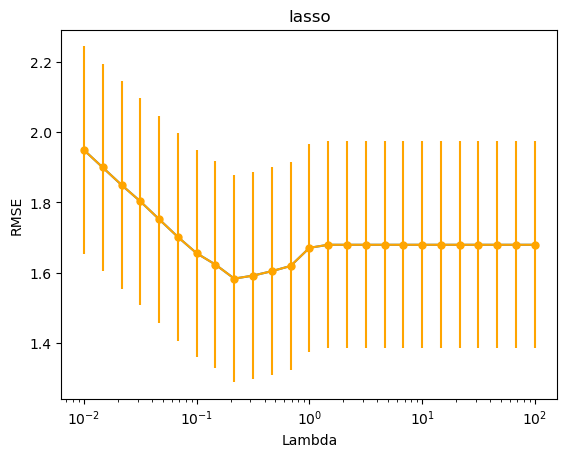

CV lambda 1 std rule for lasso-lars is 100.0
min val error is 1.5834929871261045. This is the RMSE


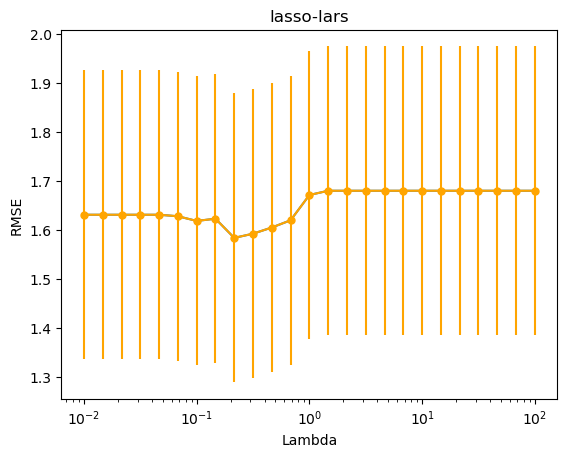

CV lambda 1 std rule for ridge is 100.0
min val error is 1.8318421336817095. This is the RMSE


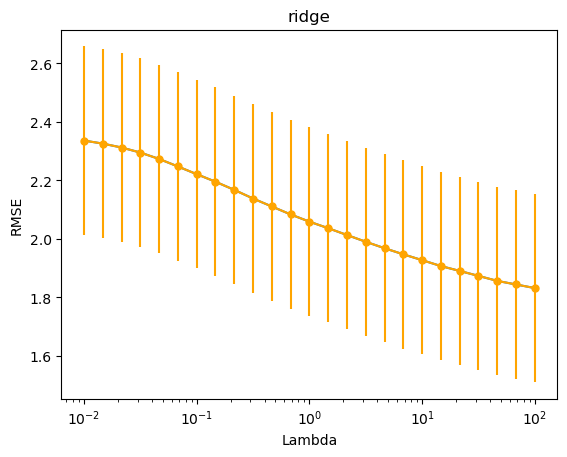

CV lambda 1 std rule for elastic_net is 100.0
min val error is 1.5704504048692338. This is the RMSE


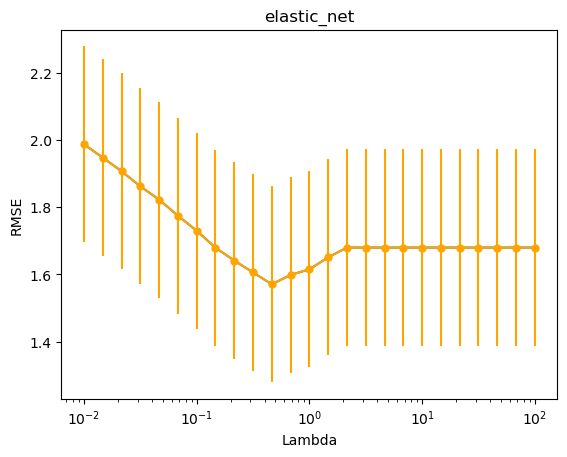

In [74]:
def devianceFunc(ytrue, yscores):
    return np.sum(np.abs(ytrue - yscores))  # RSS equivalent

regression_models = ["SVR", "baseline", "lasso","lasso-lars", "ridge", "elastic_net"]  #"lars", "decision_tree", "xgboost", "bagging-lasso" 
deviance = np.zeros((len(regression_models), K, len(lambdas)))

val_predictions = {model: [] for model in regression_models}
val_true_values = {model: [] for model in regression_models}

with warnings.catch_warnings(): # done to disable all the convergence warnings from elastic net
    warnings.simplefilter("ignore")
    
    #Setup CrossValidation loop
    for k, (train_index, test_index) in enumerate(CV.split(Xfull, Yfull_single_column)):
        print(f"starting fold {k}")
        X_train = Xfull[train_index, :]
        y_train = Yfull_single_column[train_index]
        
        y_test = Yfull_single_column[test_index]
        X_test = Xfull[test_index]

        # Standardize X
        scaler = StandardScaler()
        X_train = scaler.fit_transform(X_train)
        X_test = scaler.transform(X_test)  # Use same scaler!

        #Setup loop over possible lambdas
        for i, lambda_ in enumerate(lambdas):
            for reg_i, reg_model in enumerate(regression_models):
                
                if reg_model == "baseline":
                    y_train_mean = np.mean(y_train)  # Compute mean of y_train
                    yscores = np.full_like(y_test, y_train_mean)  # Create baseline predictions

                elif reg_model == "lasso":
                    reg = Lasso(alpha=lambda_)
                    
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)
                
                elif reg_model == "ridge":
                    #For each lambda run logistic regression
                    reg = Ridge(alpha=lambda_)
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)

                elif reg_model == "elastic_net":
                    reg = ElasticNet(alpha=lambda_, l1_ratio=0.5)  # l1_ratio=0.5 balances Lasso and Ridge
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)

                elif reg_model == "lars":
                    value = np.sqrt(1/np.min(lambdas)*lambda_)  # You can tune this
                    n_nonzero_coefs = min(40, int(round(value)))

                    reg = Lars(
                        fit_intercept=True,  # Whether to include an intercept term
                        n_nonzero_coefs = n_nonzero_coefs
                    )
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)

                elif reg_model == "lasso-lars":

                    reg = LassoLars(
                        alpha=lambda_,
                        fit_intercept=True,
                        max_iter=20,     # You can increase for more precision
                    )
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)


                elif reg_model == "decision_tree":
                    reg = DecisionTreeRegressor(
                        max_depth=5,  # Limits tree depth
                        min_samples_split=10,  # Min samples needed to split an internal node
                        min_samples_leaf=5,  # Min samples needed in a leaf node
                        max_features="sqrt",  # Limits number of features considered for each split
                        random_state=seed
                    )
                    
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)
                elif reg_model == "xgboost":
                    
                    value = np.sqrt(1/np.min(lambdas)*lambda_)  # You can tune this
                    max_depth = min(5, int(round(value)))

                    reg = XGBRegressor(
                        objective="reg:squarederror", 
                        reg_lambda=lambda_,  # L2 regularization (like Ridge)
                        random_state=seed,  # Ensures reproducibility
                        max_depth = max_depth,
                        learning_rate=0.05,

                    )
                    
                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)

                elif reg_model == "SVR":
                    reg = SVR(
                        kernel='linear',
                        C=lambda_,          # Regularization parameter
                        gamma='auto',      # Kernel coefficient (can be adjusted or set to a float)
                        epsilon=0.001,         # Epsilon-tube within which no penalty is associated
                        degree=10
                    )

                    reg.fit(X_train, y_train)
                    yscores = reg.predict(X_test)
                

                elif reg_model == "bagging-lasso":
                    n_estimators = 100  # or 50, depending on time
                    preds = []

                    for _ in range(n_estimators):
                        # Bootstrap sample
                        indices = np.random.choice(len(X_train), size=len(X_train), replace=True)
                        X_boot = X_train[indices]
                        y_boot = y_train[indices]

                        # Fit Lasso on bootstrap sample
                        reg = Lasso(alpha=lambda_)
                        reg.fit(X_boot, y_boot)

                        # Predict on test set
                        preds.append(reg.predict(X_test))

                    # Average predictions
                    yscores = np.mean(preds, axis=0)


                RSS = devianceFunc(y_test, yscores)

                deviance[reg_i, k, i] = RSS

                val_predictions[reg_model].append(yscores)
                val_true_values[reg_model].append(y_test)


#Compute the average and std of the deviance over CV folds
best_lambdas = {}
for regr_mod in range(len(regression_models)):
    testError = np.sum(deviance[regr_mod], axis=0) / Yfull_single_column.shape[0]  #we do across axis=0, because this axis corrosponds to the folds, meaning we average across all elements of the same column
    testStd = np.std(deviance[regr_mod] / Yfull_single_column.shape[0], axis=0)
    k = np.argmin(testError)
    testStd = testStd[k]
    #Select the optimal lambda using the 1-std-rule
    Lambda_CV_1StdRule = lambdas[testError < min(testError) + testStd][-1]
    best_lambdas[regression_models[regr_mod]] = Lambda_CV_1StdRule
    print(f"CV lambda 1 std rule for {regression_models[regr_mod]} is {Lambda_CV_1StdRule}")

    plt.figure()
    plt.errorbar(lambdas, testError, testStd, marker='.', color='orange', markersize=10)
    plt.semilogx(lambdas, testError)

    print(f"min val error is {min(testError)}. This is the RMSE")
    plt.xlabel("Lambda")
    plt.ylabel("RMSE")
    plt.title(f"{regression_models[regr_mod]}")
    plt.show()
